# Lumoshive Data Science Final Project

### Basic Configurations

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np
import math
import seaborn as sns
import re

## SKlearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report,precision_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.calibration import LabelEncoder

In [4]:
df_tr = pd.read_csv("transactions_mix.csv")
df_sb = pd.read_csv("subscriptions_mix.csv")
df_sb2 = pd.read_csv("subscriptions_60000.csv")
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)

C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\2935553958.py:1: DtypeWarning: Columns (4,6,10,13,14,15,16,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tr = pd.read_csv("transactions_mix.csv")
C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\2935553958.py:2: DtypeWarning: Columns (4,6,10,13,16,18,20,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb = pd.read_csv("subscriptions_mix.csv")
C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\2935553958.py:3: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sb2 = pd.read_csv("subscriptions_60000.csv")


### Data Cleaning

#### Concatenate Old & New Sub Table

In [5]:
df_merge = pd.concat([df_sb, df_sb2])

# for i in df_merge["handset"].unique():
#     print(i)

In [6]:
#High percentage of missing value, so we drop these columns
cols_drop = {
    'freemium_end_date',
    'unsubs_from', 
    'publisher',
    'trxid',
    'pixel',
    'handset',
    'browser',
}

df_merge.drop(cols_drop, axis=1, inplace=True)

df_merge.drop(df_merge[df_merge['cycle'].isna()].index, inplace = True)

In [7]:
## Since currency of "Kip" & "LAK" are the same. We will change Kip to Lak
df_merge["currency"] = df_merge["currency"].astype(str).apply(lambda x : "LAK" if x == "Kip" else x)

## Upper and Lowercasing string
df_merge["operator"] = df_merge["operator"].astype(str).apply(lambda x : x.lower())
df_merge["source"] = df_merge["source"].astype(str).apply(lambda x : x.lower())
df_merge["service"] = df_merge["service"].astype(str).apply(lambda x : x.lower())
df_merge["country"] = df_merge["country"].astype(str).apply(lambda x : x.upper())
df_merge["profile_status"] = df_merge["profile_status"].astype(str).apply(lambda x : x.lower())

## Cleaning the adnet by splitting them.
df_merge["adnet"] = df_merge["adnet"].astype(str).apply(lambda x : x.split("-")[0].lower())
df_merge["adnet"] = df_merge["adnet"].replace('nan', np.nan) ## Let nan be NaN numpy
df_merge.dropna(subset=['adnet'], inplace=True)

df_sb2["adnet"] = df_sb2["adnet"].astype(str).apply(lambda x : x.split("-")[0].lower())
df_sb2["adnet"] = df_sb2["adnet"].replace('nan', np.nan) ## Let nan be NaN numpy
df_sb2.dropna(subset=['adnet'], inplace=True)

## Currency Changes
df_merge["currency"] = np.where(df_merge["country"] == "ID", df_merge["currency"].fillna("IDR"), df_merge["currency"])
df_merge["currency"] = np.where(df_merge["country"] == "SN", df_merge["currency"].fillna("XOF"), df_merge["currency"])

## We also do not know which source does "SN" use, therefore we can fill the NaN value to Unknown / Another option that we can use impute.
df_merge['source'].fillna("None", inplace=True)

## There is a wild "2" which we do not know what does it mean, so it is better to drop it
df_merge.drop(df_merge[df_merge['status'] == 2].index, inplace = True)

In [8]:
df_merge['subs_date'] = df_merge['subs_date'].astype(str)
df_merge['subs_date'] = df_merge['subs_date'].str.split().str[0]

df_merge['renewal_date'] = df_merge['renewal_date'].astype(str)
df_merge['renewal_date'] = df_merge['renewal_date'].str.split().str[0]

df_merge['unsubs_date'] = df_merge['unsubs_date'].astype(str)
df_merge['unsubs_date'] = df_merge['unsubs_date'].str.split().str[0]

df_merge['subs_date'] = pd.to_datetime(df_merge['subs_date'], errors= 'coerce')
df_merge['renewal_date'] = pd.to_datetime(df_merge['renewal_date'], errors='coerce')
df_merge['unsubs_date'] = pd.to_datetime(df_merge['unsubs_date'], errors='coerce')


# Duration can be minus, will be thought later
# df_merge["duration"] = (df_merge['unsubs_date'] - df_merge['subs_date']).dt.days

In [9]:
# Replace multiple values in the 'revenue' column
replacement_dict = {"1000:00:00": 1000, "2000:00:00": 2000, "150:00:00":150, "0:00":0}
df_merge['revenue'] = df_merge['revenue'].replace(replacement_dict)
df_merge['service_price'] = df_merge['service_price'].replace(replacement_dict)

df_merge["revenue"] = df_merge["revenue"].astype(float)
df_merge["service_price"] = df_merge["service_price"].astype(float)

In [10]:
def convert_revenue(row):
    if row['country'] == 'SN':
        return float(row['revenue']) * 0.0018
    elif row['country'] == 'TH':
        return float(row['revenue']) * 0.032
    elif row['country'] == 'OM':
        return float(row['revenue']) * 22.6
    elif row['country'] == 'LA':
        return float(row['revenue']) * 0.00011
    elif row['country'] == 'ID':
        return float(row['revenue']) * 0.000065
    elif row['country'] == 'PH':
        return float(row['revenue']) * 0.018
  
df_merge['revenue (USD)'] = df_merge.apply(convert_revenue, axis=1)
df_merge['revenue (USD)']

df_merge_revenue_only = df_merge.query("revenue > 0")

In [15]:
df_merge.describe()

,id,status,revenue,subs_date,renewal_date,unsubs_date,service_price,attempt_charging,success_billing,revenue (USD)
count,1.770310e+05,177031.000000,177031.000000,173705,173053,97682,177031.000000,177031.000000,177031.000000,1.770310e+05
mean,1.290948e+06,0.379081,8891.187995,2023-06-05 02:22:04.853055744,2023-08-13 08:31:23.575552256,2023-05-20 06:28:31.955119872,741.028893,31.254797,6.176523,7.246502e+03
min,1.000000e+00,-1.000000,0.000000,2015-04-23 00:00:00,2022-08-30 00:00:00,2022-08-30 00:00:00,0.000000,0.000000,0.000000,0.000000e+00
25%,4.637250e+04,0.000000,0.000000,2023-04-08 00:00:00,2023-08-31 00:00:00,2023-02-18 00:00:00,6.000000,1.000000,0.000000,0.000000e+00
50%,3.548880e+05,1.000000,12.000000,2023-07-07 00:00:00,2023-09-01 00:00:00,2023-07-24 00:00:00,1000.000000,16.000000,0.000000,1.800000e-01
75%,3.962560e+05,1.000000,10000.000000,2023-08-17 00:00:00,2023-09-14 00:00:00,2023-08-03 00:00:00,1000.000000,46.000000,7.000000,1.760000e+00
max,6.008518e+07,1.000000,506000.000000,2023-12-12 00:00:00,2023-12-18 00:00:00,2023-12-11 00:00:00,10000.000000,4015.000000,1363.000000,3.132360e+06
std,4.839991e+06,0.705797,20634.787550,NaN,NaN,NaN,1088.116670,41.462777,14.814370,5.763711e+04


#### Splitting the Data

In [51]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Apply label encoding to the 'adnet' column
df_merge_revenue_only['adnet_encoded'] = label_encoder.fit_transform(df_merge_revenue_only['adnet'])

print(df_merge_revenue_only["adnet_encoded"].unique())

## Splitting the data (Using 70/30 split)
X = df_merge_revenue_only[['status', "adnet_encoded", "attempt_charging", "success_billing"]]
y = df_merge_revenue_only['revenue (USD)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[9 5 1 6 8 7 4 2 0 3]
Training set shape: (60728, 4) (60728,)
Testing set shape: (26027, 4) (26027,)


C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\2668149839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['adnet_encoded'] = label_encoder.fit_transform(df_top_10['adnet'])


### Data Training

#### Data Model / Techniques

##### Linear Regression

RMSE: 56463.98948053091
R^2: 0.44411345420849413


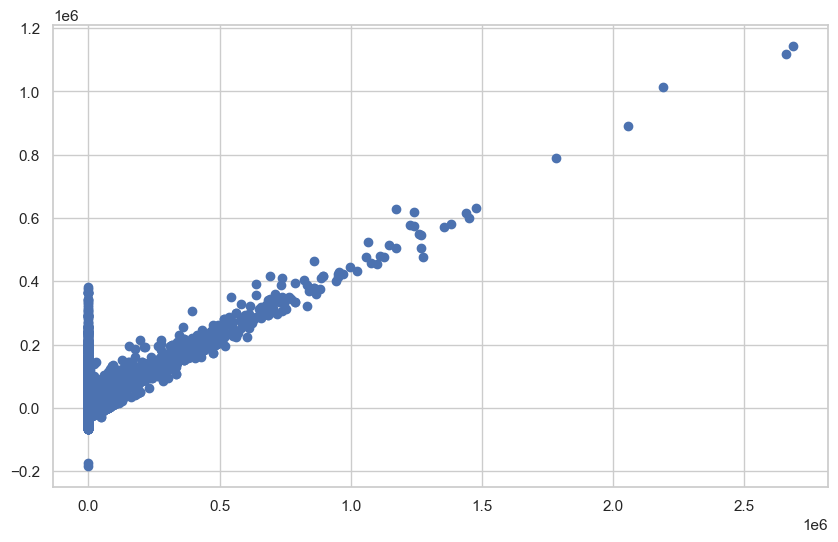

In [49]:
# Create the regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = model.predict(X_test_scaled)

# Calculating metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)


print("RMSE:", rmse)
print("R^2:", r2)

#plot linear regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)

plt.show()

##### Decision Tree

In [69]:
from sklearn.model_selection import GridSearchCV

regression_param_grid = {
    'criterion': ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


dt_regressor = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dt_regressor, cv = 3, param_grid= regression_param_grid, error_score="raise")
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

KeyboardInterrupt: 

RMSE: 12842.514418463767
R^2: 0.9712430272007276
            feature  importance
3   success_billing    0.738824
4     service_price    0.219189
2  attempt_charging    0.041843
1     adnet_encoded    0.000107
0            status    0.000037


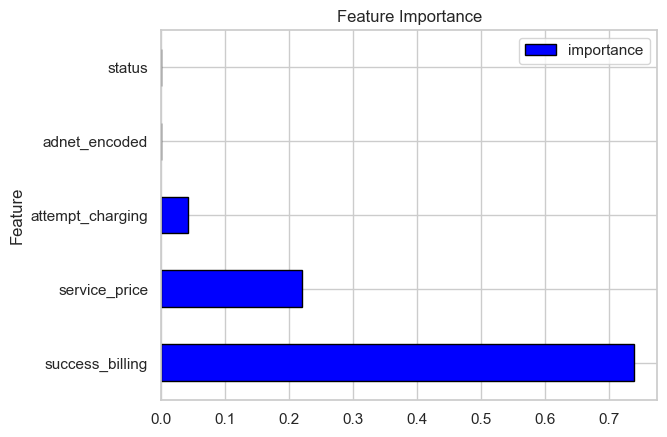

In [50]:
from sklearn.tree import export_graphviz
import graphviz

# Create the Decision Tree Regressor model
dt_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, random_state=42)
# Fit the model to the training data (use the scaled data if you have scaled it)
dt_regressor.fit(X_train_scaled, y_train)

y_pred_dt = dt_regressor.predict(X_test_scaled)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print("RMSE:", rmse_dt)
print("R^2:", r2_dt)

# Print which features are the most important and their importance values
feature_importances = dt_regressor.feature_importances_
feature_names = X.columns.tolist()
feature_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances}).sort_values('importance', ascending=False)
print(feature_df)

feature_names = X.columns.tolist()

# Export the decision tree to a dot file
dot_data = export_graphviz(dt_regressor, out_file=None, 
                           feature_names=feature_names,
                           filled=True, rounded=True, 
                           special_characters=True)

# Generate the graph from the dot file
graph = graphviz.Source(dot_data)

# Save and display the graph
graph.render("decision_tree")

# Feature importance horizantal bar plot
feature_df.plot(x='feature', y='importance', kind='barh', color='blue', edgecolor='black', )
plt.title('Feature Importance')
plt.ylabel('Feature')
plt.show()

##### Ridge Regression

RMSE: 59575.008250361534
R^2: 0.42911058713332817


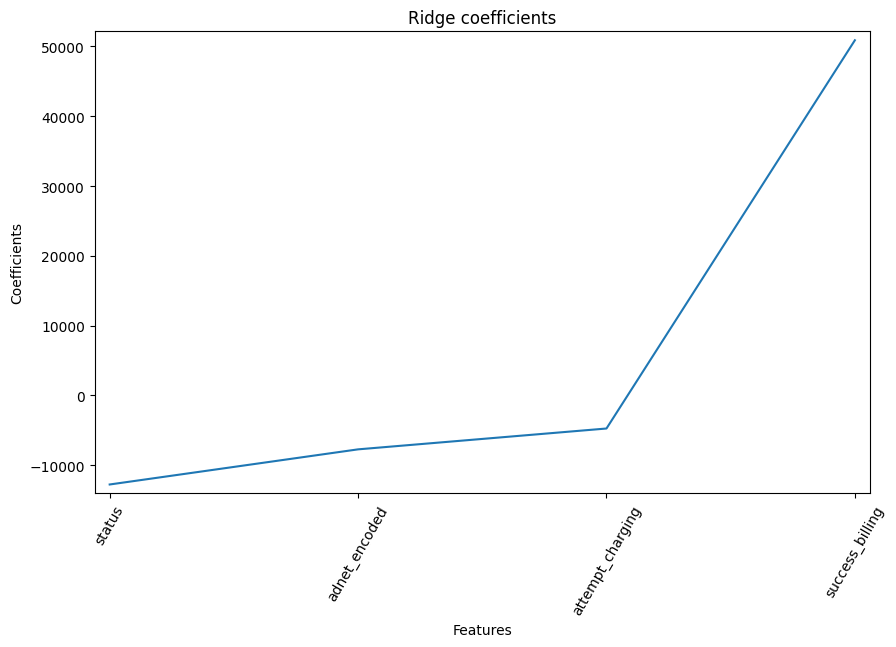

In [20]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# Initialize Ridge Regression model with an alpha value
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_reg.predict(X_test_scaled)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("RMSE:", rmse_ridge)
print("R^2:", r2_ridge)

#visualize the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X.columns)), ridge_reg.coef_)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Ridge coefficients')
plt.margins(0.02)
plt.show()

##### Lasso Regression

RMSE: 59574.99559943185
R^2: 0.4291108295934223


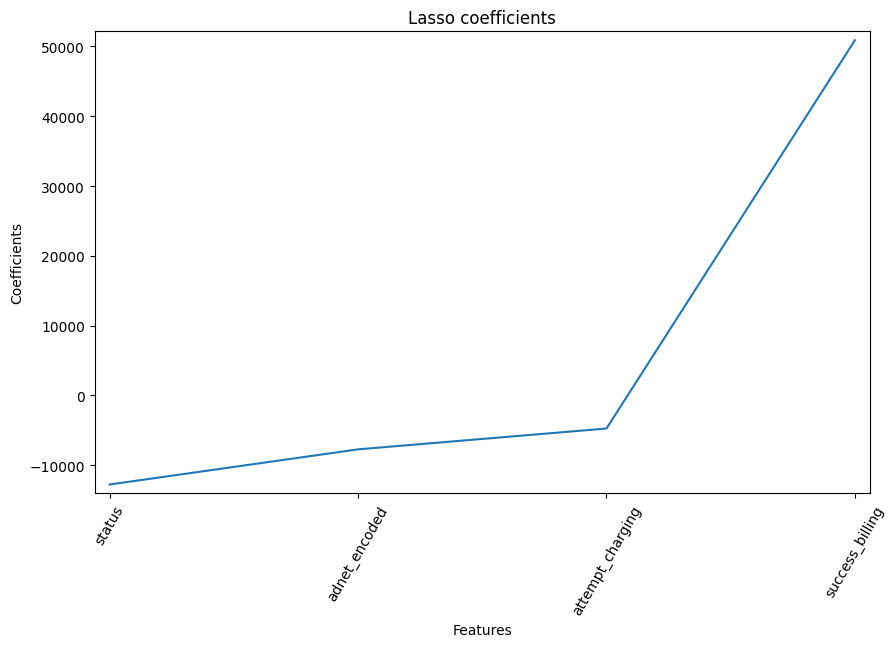

In [21]:
# Create the Lasso Regression model
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X_train_scaled, y_train)

y_pred_lasso = lasso_reg.predict(X_test_scaled)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("RMSE:", rmse_lasso)
print("R^2:", r2_lasso)

#visualize the coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(len(X.columns)), lasso_reg.coef_)
plt.xticks(range(len(X.columns)), X.columns.values, rotation=60)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients')
plt.margins(0.02)
plt.show()



##### Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

#RFR uses features names

regressor =  RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print(y_pred.shape)

rmse = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE: ", rmse)
print("R2", r2)
# print("Regressor Score", regressor.score(X_train_scaled, y_train))

# # Feature importance
# feature_importance = regressor.feature_importances_
# print("Feature importance:\n", feature_importance)

# # Print which features are the most important and their importance values
# feature_importance_df = pd.DataFrame({"feature": feature_names, "importance": feature_importance}).sort_values("importance", ascending=True)
# feature_importance_df

# # Feature importance bar plot
# feature_importance_df.plot(x="feature", y="importance", kind="barh", color="red", edgecolor="black")
# plt.title("Feature Importance")
# plt.ylabel("Feature")
# plt.show()



# single_tree = regressor.estimators_[0]

# dot_data = export_graphviz(single_tree, out_file=None, 
#                            feature_names=feature_names,  # Make sure to provide the correct feature names
#                            filled=True, rounded=True, 
#                            special_characters=True)

# # Draw graph
# graph = graphviz.Source(dot_data)

# # Save and display the graph
# graph.render("single_tree")
# graph

(27588,)
RMSE:  13127.597410838122
R2 0.429110870785838


##### SVR (Support Vector Regression)

In [23]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train)

y_pred = svr.predict(X_test)

mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)


##### K-Neighbors Regressor

In [121]:
from sklearn.neighbors import KNeighborsRegressor


knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)

Mean Absolute Error: 1106.733858546413
Mean Squared Error:  17815.358813577324
R-squared (R2) Score:  0.9165721928379211


Mean Absolute Error: 12369.404142498814
Mean Squared Error:  1608631101.649587
R-squared (R2) Score:  0.5771579766651842


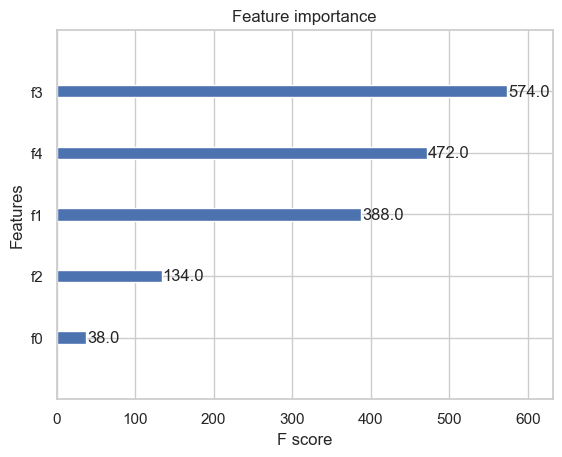

In [122]:
#XGBoost Regressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# give the code below command to understand better
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

xg_reg.fit(X_train_scaled,y_train)

y_pred = xg_reg.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

print("Mean Squared Error: ", mse)
print("R-squared (R2) Score: ", r2)


# visualize the feature importance
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()



ADABoost


### Data Visualization

#### ANOVA & T-Test

C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\3014694668.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  count_bar_plot = sns.barplot(x='adnet', y='revenue', data=sorted_adnets, palette='viridis')


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'marvel'),
  Text(1, 0, 'star'),
  Text(2, 0, 'lig'),
  Text(3, 0, 'fmd'),
  Text(4, 0, 'kee'),
  Text(5, 0, 'default'),
  Text(6, 0, 'mbp'),
  Text(7, 0, 'outrix'),
  Text(8, 0, 'mvls'),
  Text(9, 0, 'mpl')])

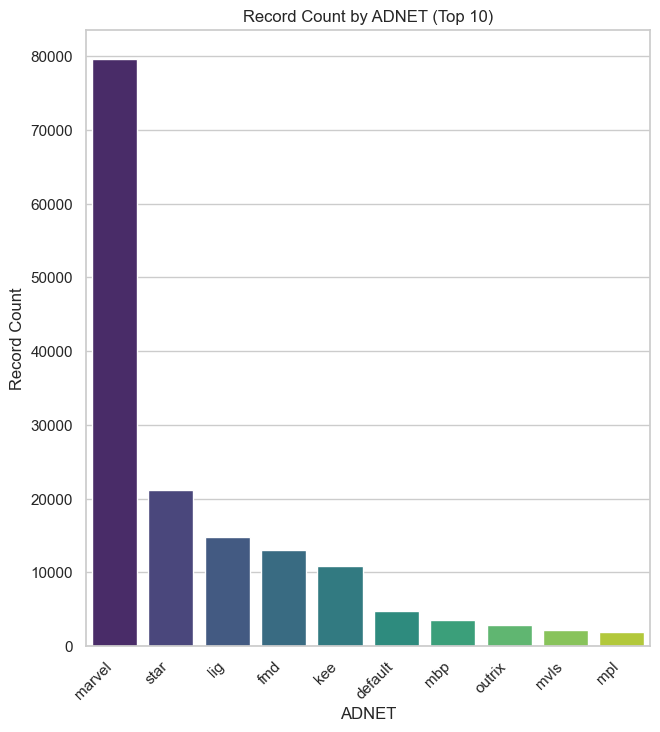

In [70]:
df_merge["revenue"] = df_merge['revenue'].astype(int)
df_merge["service_price"] = df_merge['service_price'].astype(float)

# Count the number of records for each adnet
count_by_adnet = df_merge.groupby('adnet')['revenue'].count().reset_index()

# Sort by count in descending order to highlight the top adnets
sorted_adnets = count_by_adnet.sort_values(by='revenue', ascending=False).head(10)

# Set Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for count of records
plt.figure(figsize=(16, 8))

# Bar plot for count
plt.subplot(1, 2, 1)
count_bar_plot = sns.barplot(x='adnet', y='revenue', data=sorted_adnets, palette='viridis')
plt.xlabel('ADNET')
plt.ylabel('Record Count')
plt.title('Record Count by ADNET (Top 10)')
plt.xticks(rotation=45, ha='right')

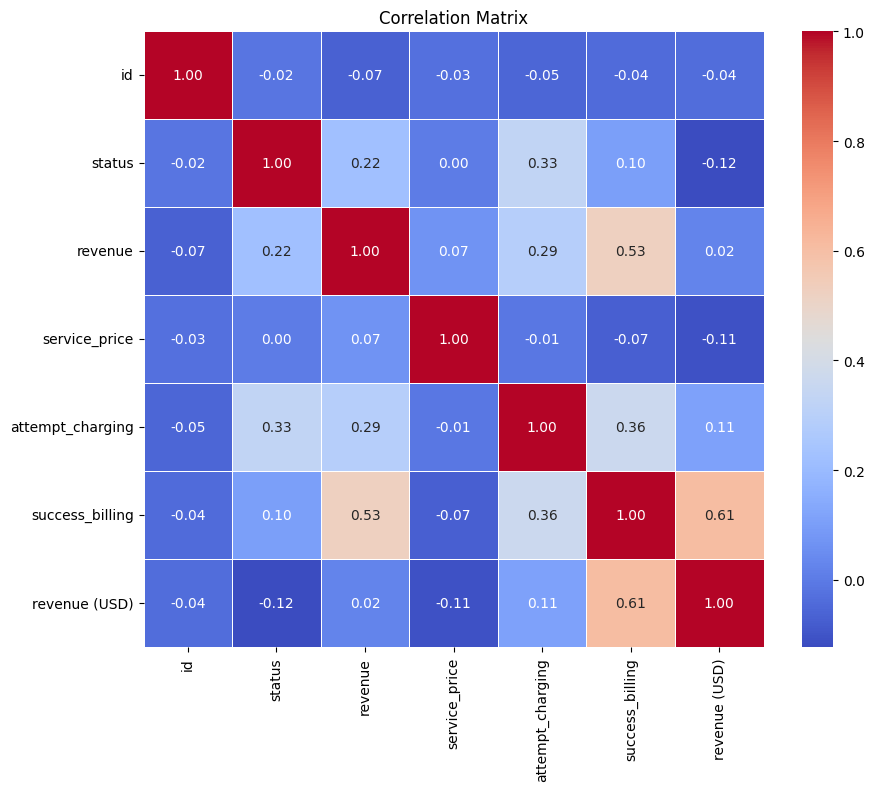

In [11]:
correlation_matrix = df_merge_revenue_only.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Display the plot
plt.title("Correlation Matrix")
plt.show()

In [62]:
# Group by ADNET and calculate total revenue for each ADNET
adnet_avg_revenue = df_merge_revenue_only.groupby('adnet')['revenue'].count().reset_index()

# Sort the DataFrame by total revenue in descending order
sorted_adnet_avg_revenue = adnet_avg_revenue.sort_values(by='revenue', ascending=False)

# Retrieve the top 10 ADNETs based on total revenue
top_10_adnets_avg_revenue = sorted_adnet_avg_revenue.head(10)

# Filter the original DataFrame to include only the rows corresponding to the top 10 ADNETs
df_top_10 = df_merge_revenue_only[df_merge_revenue_only['adnet'].isin(top_10_adnets_avg_revenue['adnet'])]

df_adnet = df_merge_revenue_only.query("adnet == 'fmd'")["revenue (USD)"]
df_adnet.astype(int).describe()

count    6.466000e+03
mean     8.366474e+04
std      1.783680e+05
min      6.780000e+03
25%      6.780000e+03
50%      2.034000e+04
75%      6.780000e+04
max      2.684880e+06
Name: revenue (USD), dtype: float64

In [ ]:
import scipy.stats as stats

# Assuming you have a DataFrame named df_merge with 'adnet' and 'revenue' columns

# Perform ANOVA
f_statistic, p_value = stats.f_oneway(
    df_top_10['revenue'][df_top_10['adnet'] == 'marvel'].astype(int),
    df_top_10['revenue'][df_top_10['adnet'] == 'star'].astype(int),
    # Add more adnets as needed
)

print(f"Formatted p-value: {p_value:.16f}")

# Check the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in revenue among different advertisement networks.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in revenue among different advertisement networks.")


In [66]:
import itertools
import scipy.stats as stats

# List of unique ad networks
adnets = df_top_10['adnet'].unique()

# Set the significance level
alpha = 0.05

# Loop through each pair of ad networks
for adnet1, adnet2 in itertools.combinations(adnets, 2):
    # Extract revenue data for the current ad networks
    adnet1_data = df_top_10[df_top_10["adnet"] == adnet1]['revenue (USD)']
    adnet2_data = df_top_10[df_top_10["adnet"] == adnet2]['revenue (USD)']
    
    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(adnet1_data, adnet2_data)
    
    # Display results
    print(f"\nComparison between {adnet1} and {adnet2}")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

    # Check significance
    if p_value < alpha:
        print("Reject the null hypothesis. There is significant evidence of a difference in means.")
    else:
        print("Fail to reject the null hypothesis. There is not enough evidence to conclude a difference in means.")

adnets = df_top_10['adnet'].unique()

for adnet in adnets:
    # Extract revenue data for the current ad network
    adnet_data = df_top_10[df_top_10["adnet"] == adnet]['revenue (USD)']
    
    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(adnet_data)

    # Display results
    print(f"\nANOVA results for {adnet}")
    print(f"F-statistic: {f_statistic}")
    print(f"P-value: {p_value}")

    # Check significance
    if p_value < alpha:
        print("Reject the null hypothesis. There is significant evidence of a difference in means.")
    else:
        print("Fail to reject the null hypothesis. There is not enough evidence to conclude a difference in means.")


Comparison between star and lig
F-statistic: 145.11283645558603
P-value: 7.867345058333516e-33
Reject the null hypothesis. There is significant evidence of a difference in means.

Comparison between star and default
F-statistic: 559.3737177332152
P-value: 2.2952874250833906e-118
Reject the null hypothesis. There is significant evidence of a difference in means.

Comparison between star and marvel
F-statistic: 1438.7185512905235
P-value: 2.1054126072677e-311
Reject the null hypothesis. There is significant evidence of a difference in means.

Comparison between star and outrix
F-statistic: 1733.837076877915
P-value: 0.0
Reject the null hypothesis. There is significant evidence of a difference in means.

Comparison between star and movi
F-statistic: 474.90379295281406
P-value: 3.638624885379967e-98
Reject the null hypothesis. There is significant evidence of a difference in means.

Comparison between star and kee
F-statistic: 633.0078740580994
P-value: 1.3870777347604977e-133
Reject the 

TypeError: at least two inputs are required; got 1.

C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\1256337714.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='revenue (USD)', data=df_top_10, orient='h', showfliers=False, palette='viridis')


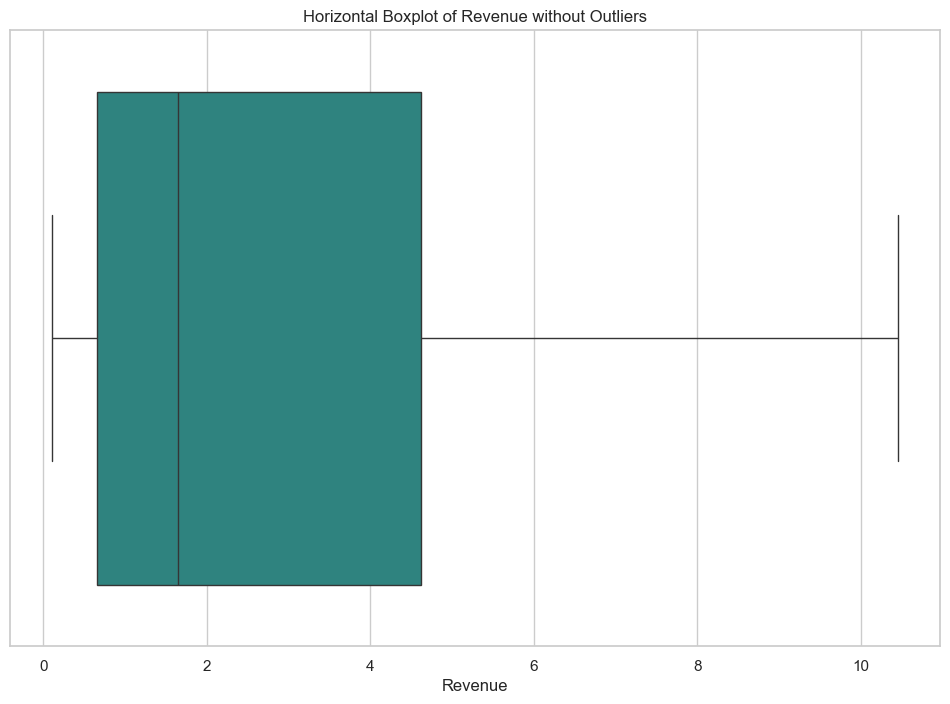

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df_top_10' is your DataFrame with a 'revenue' column
plt.figure(figsize=(12, 8))
sns.boxplot(x='revenue (USD)', data=df_top_10, orient='h', showfliers=False, palette='viridis')
plt.xlabel('Revenue')
plt.title('Horizontal Boxplot of Revenue without Outliers')
plt.show()


C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\3584412179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_10['adnet'] = df_top_10['adnet'].astype('category')
C:\Users\samsu\AppData\Local\Temp\ipykernel_19976\3584412179.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='adnet', y='revenue', data=df_top_10, palette='viridis', showfliers=False,)


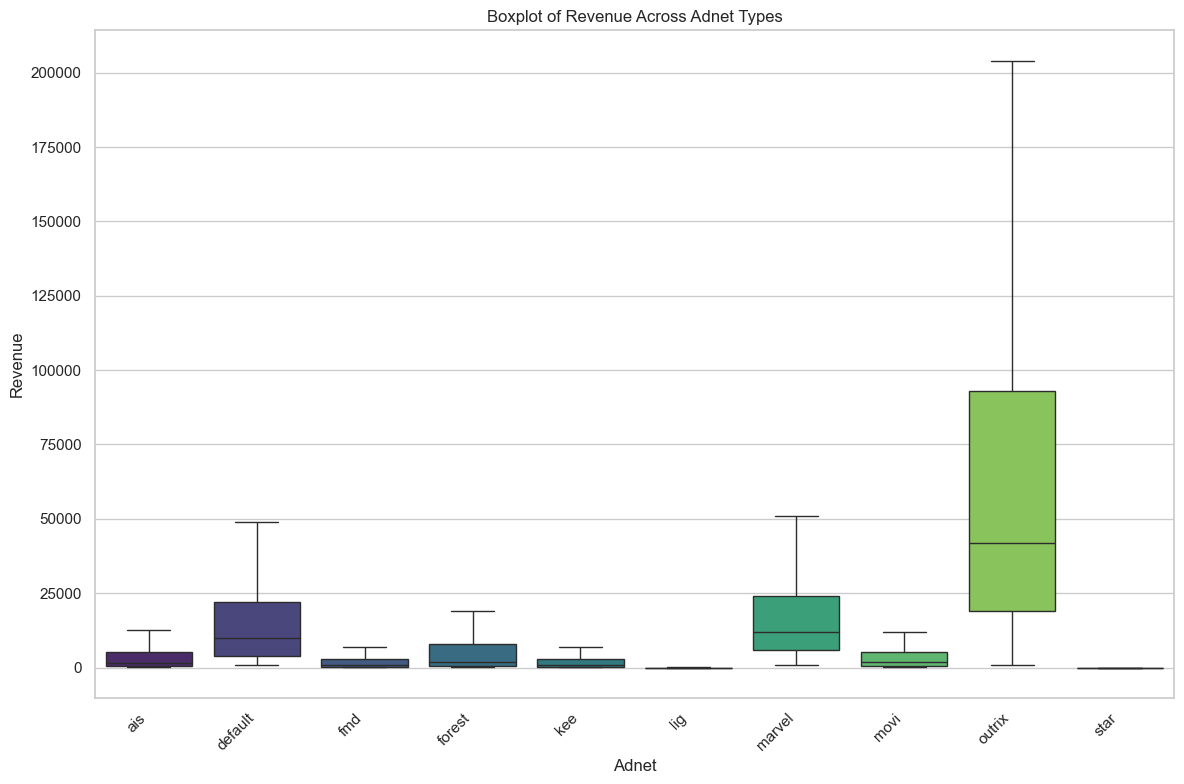

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Ensure the 'adnet' column is categorical
df_top_10['adnet'] = df_top_10['adnet'].astype('category')



# Boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='adnet', y='revenue', data=df_top_10, palette='viridis', showfliers=False,)
plt.xlabel('Adnet')
plt.ylabel('Revenue')
plt.title('Boxplot of Revenue Across Adnet Types')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.show()


In [75]:
# T-Test
from scipy.stats import ttest_rel
from itertools import combinations

# Assuming df_merge has columns 'adnet' and 'revenue'
adnets = df_top_10['adnet'].unique()

listA = df_top_10.query("adnet == 'marvel'")["revenue"].astype(int).tolist()
listB = df_top_10.query("adnet == 'outrix'")["revenue"].astype(int).tolist()

min_length = min(len(listA), len(listB))
before_treatment =listA[:min_length]
after_treatment = listB[:min_length]

ttest, p_value = ttest_rel(before_treatment, after_treatment)

print(p_value)


1.7466990529509419e-293


#### Visualization P2

C:\Users\samsu\AppData\Local\Temp\ipykernel_33336\1937857030.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_merge_revenue_only, x='country', palette='hsv', order=df_merge_revenue_only['country'].value_counts().index)


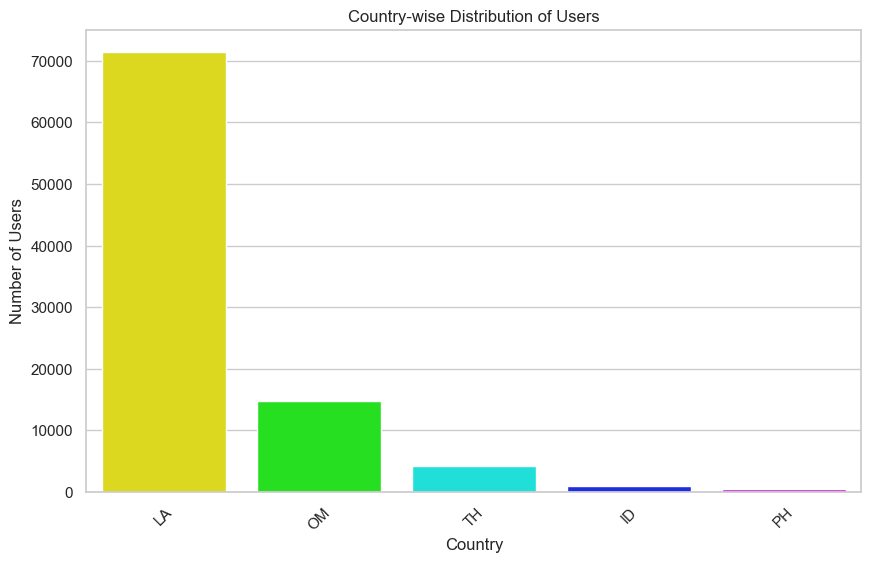

In [24]:
# Setting the visualization style
sns.set(style="whitegrid")

# Country-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_merge_revenue_only, x='country', palette='hsv', order=df_merge_revenue_only['country'].value_counts().index)
plt.title('Country-wise Distribution of Users')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\4283262548.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_merge['operator'].value_counts().index)


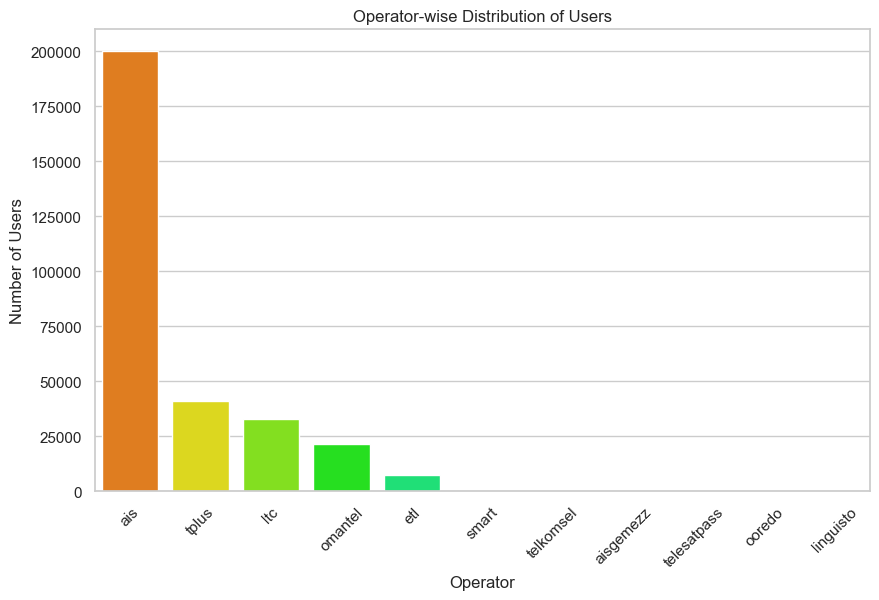

In [46]:
# Operator-wise Distribution Visualization using cleaned subscriptions data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Operator-wise Distribution of Users')
plt.xlabel('Operator')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


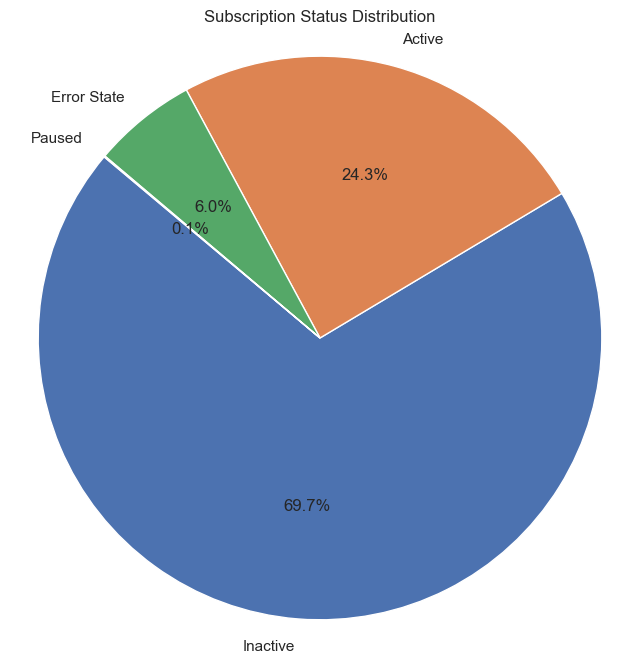

In [22]:

status_meanings = {
    -1: 'Error State',
    0: 'Inactive',  
    1: 'Active',    
    2: 'Paused'  
}

# Map the status codes to meanings
df_sb['status_label'] = df_sb['status'].map(status_meanings)

# Subscription Status Visualization: Pie Chart
status_counts = df_sb['status_label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Subscription Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


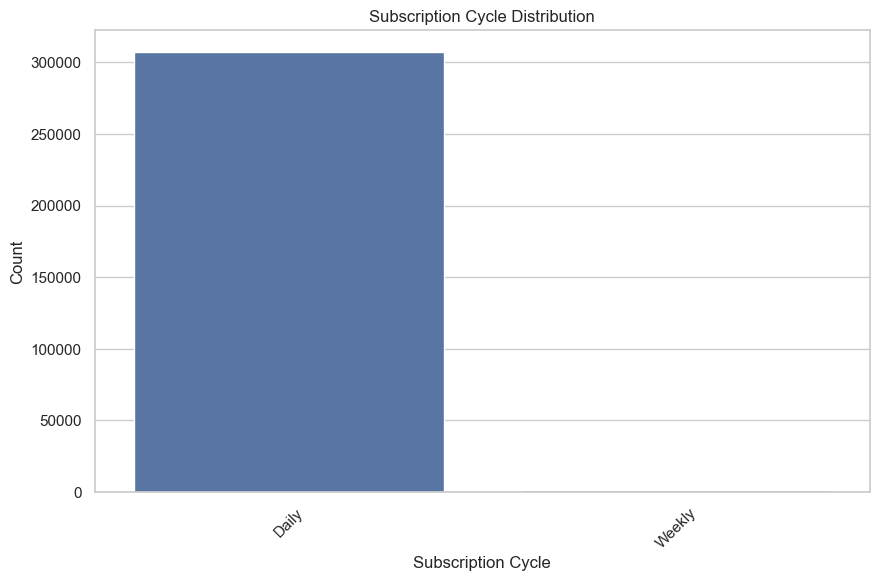

In [23]:
cycle_meanings = {
    'daily': 'Daily',
    'weekly': 'Weekly',
    'monthly': 'Monthly',
    # ... add other cycles as necessary
}

# Map the cycle codes to meanings
df_sb['cycle_label'] = df_sb['cycle'].map(cycle_meanings)

# Subscription Cycle Visualization: Bar Chart
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Cycle Distribution')
plt.xlabel('Subscription Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [24]:
df_sb

,id,created_at,country,operator,service,source,msisdn,status,cycle,adnet,revenue,subs_date,renewal_date,freemium_end_date,unsubs_from,unsubs_date,service_price,currency,profile_status,publisher,trxid,pixel,handset,browser,attempt_charging,success_billing,status_label,cycle_label
0,302164,2023-09-13 09:47:57.713,TH,ais,459505104,sms,66988602911,0,daily,NaN,0,2022-10-20 19:28:02.000,2023-09-14 00:00:00.000,2022-10-20 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070749401088.0,NaN,NaN,NaN,15,0,Inactive,Daily
1,3521,2023-09-13 09:21:13.679,TH,ais,459505104,sms,66822243080,0,daily,NaN,0,2020-08-23 16:11:02.000,2023-09-14 00:00:00.000,2020-08-23 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070724300800.0,NaN,NaN,NaN,15,0,Inactive,Daily
2,1,2023-09-13 09:20:20.727,TH,ais,459505106,ivr,666131,0,1,NaN,6,2023-08-25 14:02:05.000,2023-08-26 00:00:00.000,2023-08-25 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230825140205699072.0,NaN,NaN,NaN,1,1,Inactive,NaN
3,4999335,2023-09-13 14:00:22.171,TH,ais,459505105,wap,66650020857,0,daily,star,0,2023-09-09 13:03:24.000,2023-09-14 00:00:00.000,2023-09-09 00:00:00.000,NaN,NaN,6,BATH,Active,star,20230913071052099584.0,star-APP1694223212644066,NaN,NaN,5,0,Inactive,Daily
4,273196,2023-09-13 09:45:33.449,TH,ais,459505104,sms,66635959286,0,daily,NaN,0,2022-09-26 19:36:03.000,2023-09-14 00:00:00.000,2022-09-26 00:00:00.000,NaN,NaN,6,BATH,Active,NaN,20230913070115598336.0,NaN,NaN,NaN,15,0,Inactive,Daily
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308906,22019,2023-09-14 06:55:36.464,OM,omantel,goaly,cp1,96898097014,0,daily,kee,0,2023-05-11 09:50:11.000,2023-05-11 09:50:26.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308907,22037,2023-09-14 06:55:36.475,OM,omantel,goaly,cp1,96872209910,0,daily,kee,0,2023-05-11 09:49:50.000,2023-05-11 09:50:09.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308908,22062,2023-09-14 06:55:36.485,OM,omantel,goaly,cp1,96891448321,0,daily,kee,0,2023-05-11 06:15:24.000,2023-05-11 06:15:52.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily
308909,22083,2023-09-14 06:55:36.498,OM,omantel,goaly,cp1,96891982806,0,daily,kee,0,2023-05-11 16:44:57.000,2023-05-11 16:45:19.000,NaN,NaN,0001-01-01 00:00:00.000,300,Rial,NaN,lumos,NaN,NaN,/,Apache-HttpClient,1,0,Inactive,Daily


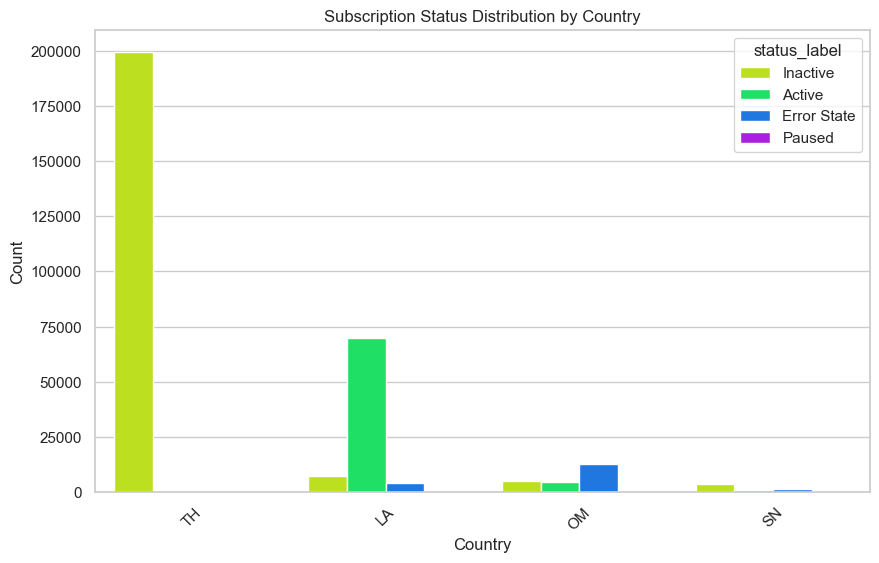

In [25]:
# Subscription Status Distribution by Country
df_sb.groupby(['country', 'operator', 'status_label']).size().reset_index(name='counts')

# Subscription Status Distribution by Country
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='country', hue='status_label', palette='hsv', order=df_sb['country'].value_counts().index)
plt.title('Subscription Status Distribution by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

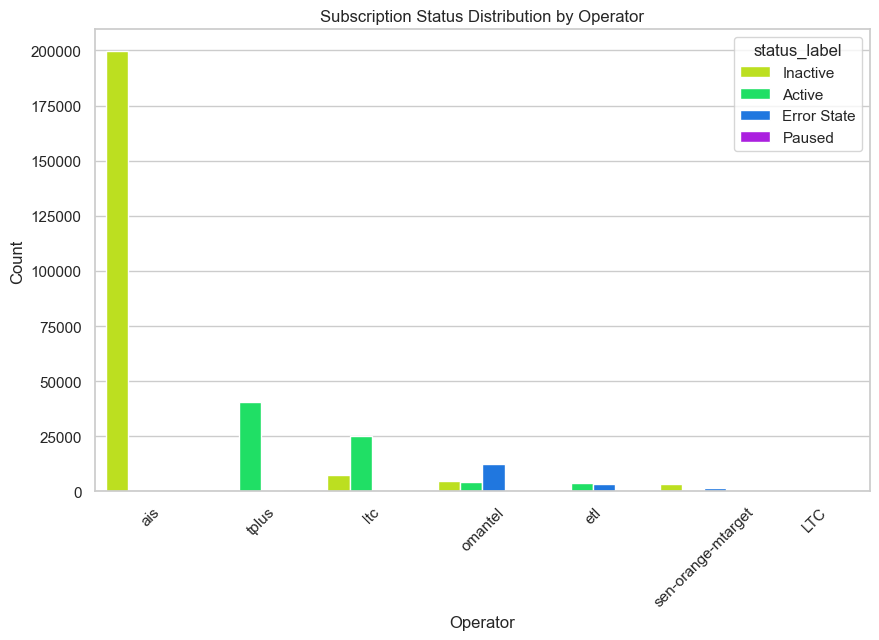

In [26]:

# Subscription Status Distribution by Operator
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='operator', hue='status_label', palette='hsv', order=df_sb['operator'].value_counts().index)
plt.title('Subscription Status Distribution by Operator')
plt.xlabel('Operator')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


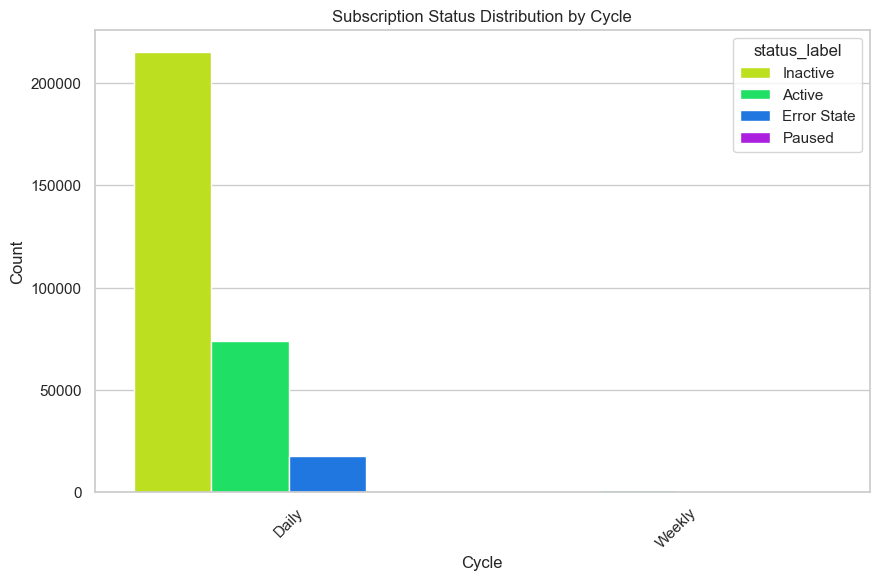

In [27]:
# Subscription Status Distribution by Cycle
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='cycle_label', hue='status_label', palette='hsv', order=df_sb['cycle_label'].value_counts().index)
plt.title('Subscription Status Distribution by Cycle')
plt.xlabel('Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


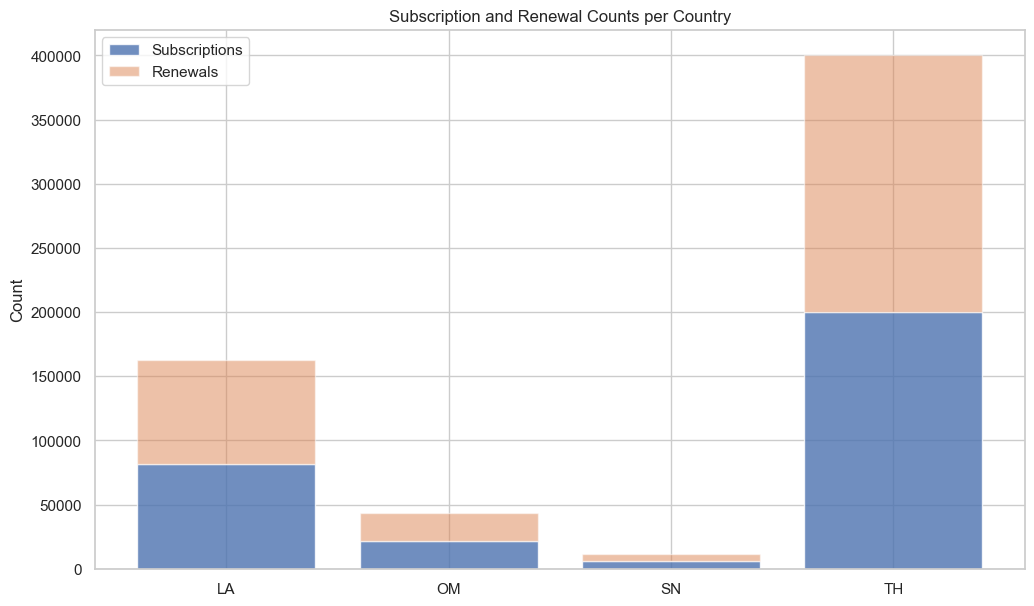

In [28]:
subscriptions_count = df_sb.groupby('country').size().reset_index(name='Subscription_Count')
renewals_count = df_sb.groupby('country').size().reset_index(name='Renewal_Count')
subs_renewals_per_country = pd.merge(subscriptions_count, renewals_count, on='country', how='outer').fillna(0)
plt.figure(figsize=(12, 7))
countries = subs_renewals_per_country['country']
subscription_counts = subs_renewals_per_country['Subscription_Count']
renewal_counts = subs_renewals_per_country['Renewal_Count']

plt.bar(countries, subscription_counts, align='center', alpha=0.8, label='Subscriptions')
plt.bar(countries, renewal_counts, align='center', alpha=0.5, label='Renewals', bottom=subscription_counts)

# plt.xticks(y_pos, countries)
plt.ylabel('Count')
plt.title('Subscription and Renewal Counts per Country')
plt.legend()

plt.show()



In [29]:
# df_sb['subs_date'].max()

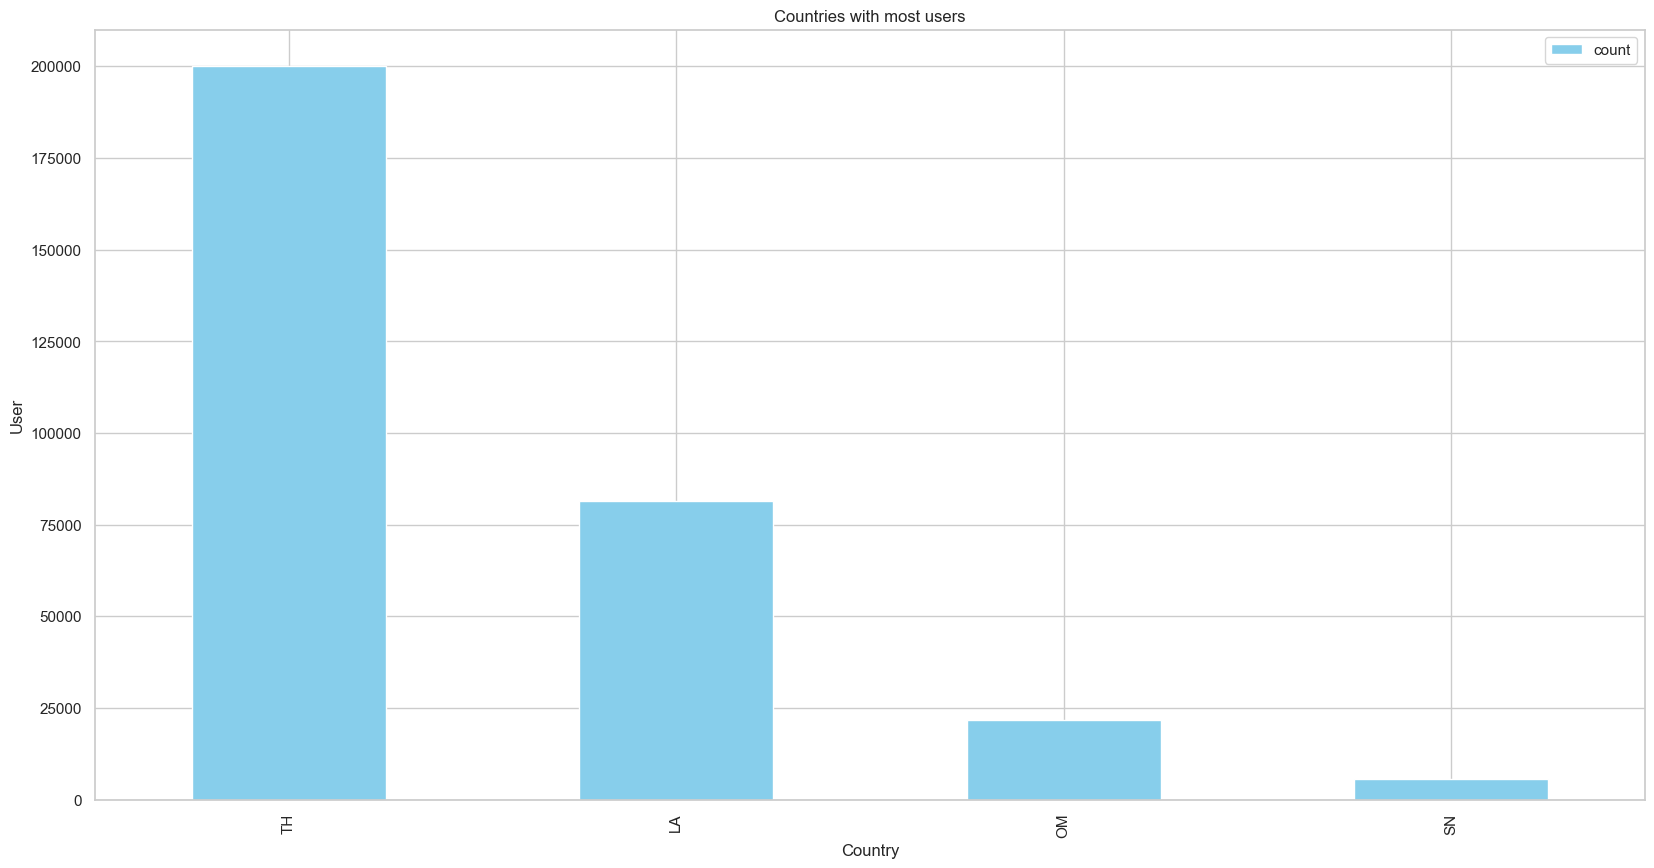

In [30]:
countries = df_sb['country'].value_counts()
topCountries = countries.head(20)
fig = plt.subplots(figsize=(20, 10))

topCountries.plot(kind='bar', color='skyblue')
plt.xlabel('Country')
plt.ylabel('User')
plt.title('Countries with most users')
plt.legend()
plt.show()



C:\Users\samsu\AppData\Local\Temp\ipykernel_16896\1210438266.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_merge['adnet'].value_counts().index)


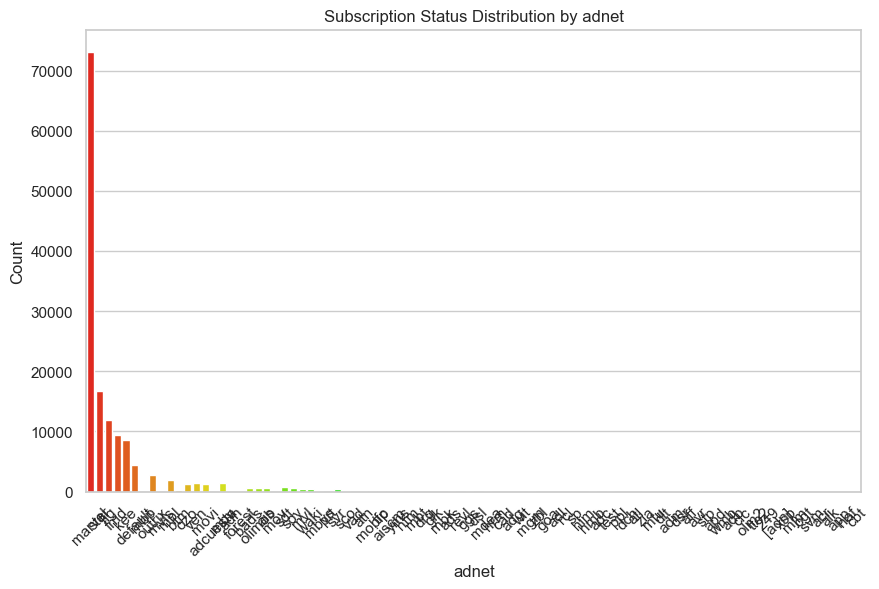

In [48]:

# revenue based on adnet
df_merge.groupby(['adnet']).size().reset_index(name='counts')

# revenue based on adnet 
#exclude nan
plt.figure(figsize=(10, 6))
sns.countplot(data=df_sb, x='adnet', palette='hsv', order=df_merge['adnet'].value_counts().index)
plt.title('Subscription Status Distribution by adnet')
plt.xlabel('adnet')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

## Renewal, Retry, Notif, Unsubscribe, First_charge, 


In [32]:
cycle_cnt = df_tr['cycle'].value_counts()
cycle_cnt.plot(kind='bar',color='skyblue')
plt.show()

## Keep this

NameError: name 'df_tr' is not defined

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 18))

#Country
sns.countplot(data=df_sb, x='country', ax=axes[0], order=df_sb['country'].value_counts().index)
axes[0].set_title('Distribution of Subscriptions by Country')
axes[0].set_ylabel('Number of Subscriptions')
axes[0].tick_params(axis='x', rotation=45)

#Service
sns.countplot(data=df_sb, x='service', ax=axes[1], order=df_sb['service'].value_counts().index)
axes[1].set_title('Distribution of Subscriptions by Service')
axes[1].set_ylabel('Number of Subscriptions')
axes[1].tick_params(axis='x', rotation=45)

#Operator
sns.countplot(data=df_sb, x='operator', ax=axes[2], order=df_sb['operator'].value_counts().index)
axes[2].set_title('Distribution of Subscriptions by Operator')
axes[2].set_ylabel('Number of Subscriptions')
axes[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

## Keep this

In [ ]:
df_sb